In [1]:
import pandas as pd
from Bio import SeqIO
import re

In [3]:
phospho_data = pd.read_csv('../data/phosphosite_sequences/Phosphorylation_site_dataset', sep='\t', skiprows=3)
phospho_data

,GENE,PROTEIN,ACC_ID,HU_CHR_LOC,MOD_RSD,SITE_GRP_ID,ORGANISM,MW_kD,DOMAIN,SITE_+/-7_AA,LT_LIT,MS_LIT,MS_CST,CST_CAT#,Ambiguous_Site
0,0610009B22Rik,0610009B22Rik,Q8R3W2,11|11 B1.3,S119-p,1868286063,mouse,16.44,Sedlin_N,NPFYEPNsPIRSSAF,NaN,1.0,NaN,NaN,1
1,1110035H17Rik,1110035H17Rik,Q9CTA4,7|7,S10-p,7231581,mouse,24.31,NaN,RPPPGSRstVAQSPP,NaN,1.0,NaN,NaN,0
2,1110035H17Rik,1110035H17Rik,Q9CTA4,7|7,T11-p,7231583,mouse,24.31,NaN,PPPGSRstVAQSPPQ,NaN,1.0,NaN,NaN,0
3,YWHAB,14-3-3 beta,P31946,20q13.12,T2-p,15718712,human,28.08,NaN,______MtMDksELV,NaN,3.0,1.0,NaN,0
4,Ywhab,14-3-3 beta,Q9CQV8,2|2 H3,T2-p,15718712,mouse,28.09,NaN,______MtMDksELV,NaN,2.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378833,ZZZ3,ZZZ3,Q8IYH5,1p31.1,S606-p,23077718,human,102.02,NaN,GLPARPksPLDPKKD,NaN,6.0,4.0,NaN,0
378834,Zzz3,ZZZ3,Q6KAQ7,3|3 H3,S613-p,23077718,mouse,102.31,NaN,GLPARPKsPLDPKKD,NaN,3.0,NaN,NaN,0
378835,ZZZ3,ZZZ3,Q8IYH5,1p31.1,Y670-p,23077724,human,102.02,Myb_DNA-binding,LEQLLIKyPPEEVEs,NaN,NaN,1.0,NaN,0
378836,ZZZ3,ZZZ3,Q8IYH5,1p31.1,S677-p,23077721,human,102.02,Myb_DNA-binding,yPPEEVEsRRWQKIA,NaN,NaN,1.0,NaN,0


In [4]:
def extract_pos_info(dataset : pd.DataFrame):
    """
    Extracts phosphoryllation site indices from the dataset. 
    Locations expected in the column 'MOD_RSD'.
    
    Returns a dictionary in format {ACC_ID : [list of phosphoryllation site indices]}
    """
    dataset['position'] = dataset['MOD_RSD'].str.extract(r'[\w]([\d]+)-p')
    dataset['acid'] = dataset['MOD_RSD'].str.extract(r'([\w])[\d]+-p')
    grouped = dataset.groupby(dataset['ACC_ID'])
    res = {}
    for id, group in grouped:
        res[id] = {}
        res[id]['acids'] = group['acid'].to_list()
        res[id]['positions'] = group['position'].to_list()

    return res

phospho_data_pos = extract_pos_info(phospho_data)

In [5]:
phospho_data_pos

{'A0A024R4G9': {'acids': ['T', 'S', 'S'], 'positions': ['14', '16', '20']},
 'A0A075B759': {'acids': ['S', 'Y', 'T', 'T'],
  'positions': ['40', '79', '93', '119']},
 'A0A087WP46': {'acids': ['S',
   'S',
   'Y',
   'S',
   'S',
   'S',
   'T',
   'S',
   'S',
   'S',
   'S'],
  'positions': ['359',
   '972',
   '973',
   '974',
   '988',
   '997',
   '1000',
   '1005',
   '1015',
   '1057',
   '1107']},
 'A0A087WPF7': {'acids': ['T',
   'T',
   'T',
   'T',
   'T',
   'S',
   'S',
   'T',
   'S',
   'S',
   'T',
   'S',
   'S',
   'T',
   'S'],
  'positions': ['32',
   '43',
   '622',
   '626',
   '798',
   '941',
   '956',
   '1031',
   '1038',
   '1107',
   '1108',
   '1200',
   '1235',
   '1240',
   '1252']},
 'A0A087WQ53': {'acids': ['Y'], 'positions': ['58']},
 'A0A087WQ89': {'acids': ['S', 'S'], 'positions': ['18', '26']},
 'A0A087WQP5': {'acids': ['S', 'S', 'S'], 'positions': ['98', '102', '107']},
 'A0A087WR82': {'acids': ['S', 'S', 'S', 'S', 'T', 'Y'],
  'positions': ['88', '

In [10]:
seq_iterator = SeqIO.parse(open("../data/phosphosite_sequences/Phosphosite_seq.fasta"), 'fasta')
seq_dict = {}
for seq in seq_iterator:
    # extract sequence id
    seq_id = seq.description.split('|')[-1]
    seq_dict[seq_id] = str(seq.seq)

In [11]:
len(seq_dict.keys())

62804

In [35]:
def create_sequence_postion_dataset(protein_data : dict, phospho_data : dict):
    """
    Creates a dataset with format { protein sequence : [list of phosphoryllation sites] } from the input datasets. 

    protein_data: should be a dictionary { protein ID : str(protein sequence)}
    phospho_data: should be a dictionary { protein_ID : [list of phosphoryllation sites] } 
    """
    res = {}
    res['id'] = []
    res['sites'] = []
    res['sequence'] = []
    res['acids'] = []
    for idx in phospho_data.keys():
        res['id'].append(idx)
        res['sequence'].append(protein_data[idx])
        res['sites'].append(phospho_data[idx]['positions'])
        res['acids'].append(phospho_data[idx]['acids'])
    return pd.DataFrame.from_dict(res, orient='columns')

sp_dataset = create_sequence_postion_dataset(seq_dict, phospho_data_pos)

In [6]:
import numpy as np

In [7]:
sp_dataset['sequence'] = sp_dataset['sequence'].apply(lambda x: np.array(list(x)))

In [8]:
idxs = sp_dataset['sites'].apply(lambda x: np.asarray(x, dtype=np.int32))

In [36]:
extracted_acids = sp_dataset.apply(lambda x: np.asarray(list(x['sequence']))[np.asarray(x['sites'], dtype=np.int32)-1], axis=1)
extracted_acids.head(5)

0                                        [T, S, S]
1                                     [S, Y, T, T]
2                [S, S, Y, S, S, S, T, S, S, S, S]
3    [T, T, T, T, T, S, S, T, S, S, T, S, S, T, S]
4                                              [Y]
dtype: object

### Check if the acids designated by the indices in the MOD_RSD column correspond to the actual acid at the given position

In [39]:
for i in extracted_acids.index:
    for a1, a2 in zip(extracted_acids[i], sp_dataset.loc[i]['acids']):
        if a1 != a2:
            break

In [40]:
phospho_data['acid'] = phospho_data['MOD_RSD'].str.extract(r'([\w])[\d]+-p')

In [41]:
phospho_data.head(5)

,GENE,PROTEIN,ACC_ID,HU_CHR_LOC,MOD_RSD,SITE_GRP_ID,ORGANISM,MW_kD,DOMAIN,SITE_+/-7_AA,LT_LIT,MS_LIT,MS_CST,CST_CAT#,Ambiguous_Site,position,prot,acid
0,0610009B22Rik,0610009B22Rik,Q8R3W2,11|11 B1.3,S119-p,1868286063,mouse,16.44,Sedlin_N,NPFYEPNsPIRSSAF,NaN,1.0,NaN,NaN,1,119,S,S
1,1110035H17Rik,1110035H17Rik,Q9CTA4,7|7,S10-p,7231581,mouse,24.31,NaN,RPPPGSRstVAQSPP,NaN,1.0,NaN,NaN,0,10,S,S
2,1110035H17Rik,1110035H17Rik,Q9CTA4,7|7,T11-p,7231583,mouse,24.31,NaN,PPPGSRstVAQSPPQ,NaN,1.0,NaN,NaN,0,11,T,T
3,YWHAB,14-3-3 beta,P31946,20q13.12,T2-p,15718712,human,28.08,NaN,______MtMDksELV,NaN,3.0,1.0,NaN,0,2,T,T
4,Ywhab,14-3-3 beta,Q9CQV8,2|2 H3,T2-p,15718712,mouse,28.09,NaN,______MtMDksELV,NaN,2.0,NaN,NaN,0,2,T,T


In [42]:
phospho_data['acid'].unique()

array(['S', 'T', 'Y', 'K', 'H', 'D', 'R', 'N', 'A', 'P', 'M', 'F', 'G',
       'L', 'I'], dtype=object)

In [59]:
code_to_name = {
    'A' : 'Alanine',
    'B' : 'Aspartic acid (D) or Asparagine',
    'C' : 'Cysteine',
    'D' : 'Aspartic acid',
    'E' : 'Glutamic acid',
    'F' : 'Phenylalanine',
    'G' : 'Glycine',
    'H' : 'Hystidine',
    'I' : 'Isoleucine',
    'J' : 'Leucine (L) or Isoleucine (I)',
    'K' : 'Lysine',
    'L' : 'Leucine',
    'M' : 'Methionine/start codon',
    'N' : 'Asparagine',
    'O' : 'Pyrrolysine',
    'P' : 'Proline',
    'Q' : 'Glutamine',
    'R' : 'Arginine',
    'S' : 'Serine',
    'T' : 'Threonine',
    'U' : 'Selenocysteine',
    'V' : 'Valine',
    'W' : 'Tryptophan',
    'Y' : 'Tyrosine',
    'Z' : 'Glutamic acid (E) or Glutamine (Q)',
    'X' : 'any'
 }

In [60]:
acid_counts = phospho_data['acid'].value_counts()
acid_counts

acid
S    239635
T     85300
Y     53853
H        20
K         7
R         6
G         4
D         3
N         2
A         2
P         2
M         1
F         1
L         1
I         1
Name: count, dtype: int64

In [1]:
phospho_data.shape

NameError: name 'phospho_data' is not defined

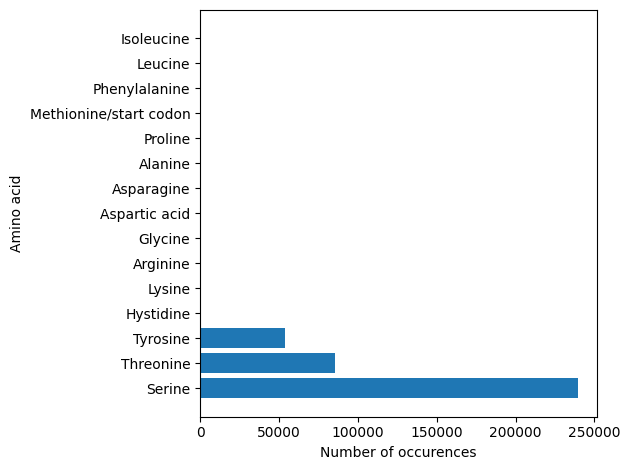

In [66]:
import matplotlib.pyplot as plt

names = [code_to_name[i] for i in acid_counts.index]
plt.barh(names, acid_counts)
plt.xlabel('Number of occurences')
plt.ylabel('Amino acid')
plt.tight_layout()

Phosphorylated%

In [12]:
cluster_data30 = pd.read_csv('../data/cluster30.tsv', sep='\t', names=['cluster_rep', 'cluster_mem'])

In [13]:
cluster_data30

,cluster_rep,cluster_mem
0,P60901,P60901
1,P60901,Q9QUM9
2,P60901,P60900
3,P10362,P10362
4,P10362,Q03517
...,...,...
42241,D3ZXD8,B1AZA5
42242,D3ZXD8,Q9H330
42243,Q9QYW0,Q9QYW0
42244,Q9QYW0,Q9JKX4


In [17]:
n_unique = len(cluster_data30.cluster_rep.unique())
print(n_unique)
print(n_unique/ cluster_data30.shape[0])

14011
0.3316527008474175


In [89]:
new_cluster_data30 = pd.read_csv('../data/clustered30_new.tsv', names=['cluster_rep', 'cluster_mem'], sep='\t')

In [90]:
n_unique = len(new_cluster_data30.cluster_rep.unique())
print(n_unique)
print(n_unique/new_cluster_data30.shape[0])

17993
0.286476245064323


In [91]:
new_cluster_data30.shape

(62808, 2)

In [92]:
grouped = new_cluster_data30.groupby('cluster_rep')
grouped.count()

,cluster_mem
cluster_rep,
A0A024R4G0,1
A0A024R4G9,1
A0A024R5B6,1
A0A024RBG1,12
A0A024RCN7,1
...,...
YP_009725309,2
YP_009725310,2
YP_009725312,1


In [93]:
grouped.count().to_numpy().flatten()

array([1, 1, 1, ..., 1, 1, 3], dtype=int64)

In [94]:
import numpy as np
group_sizes = grouped.count().to_numpy().flatten()
bins = [1, 2, 3, 4, 5, 10, 20, 50, 100, 1000]
hist = np.histogram(group_sizes, bins=bins)

In [95]:
hist

(array([4568, 2734, 5532, 1837, 2582,  616,  110,   10,    4], dtype=int64),
 array([   1,    2,    3,    4,    5,   10,   20,   50,  100, 1000]))

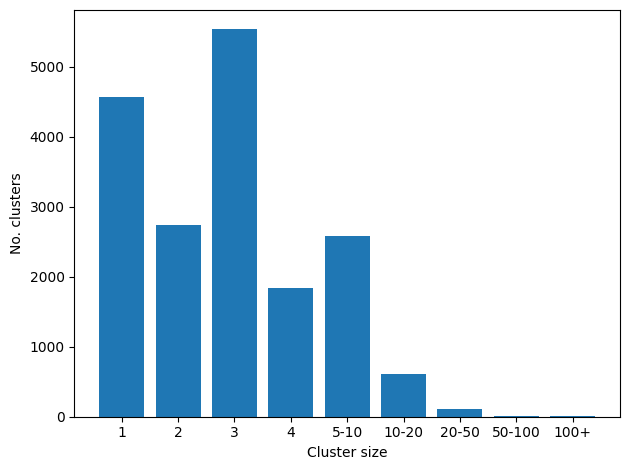

In [96]:
import matplotlib.pyplot as plt

labels = [str(i) for i in bins[:-1]]
for i in range(4, len(labels) - 1):
    labels[i] = labels[i] + '-' + labels[i + 1]

labels[-1] = labels[-1] + '+'

plt.bar(labels, hist[0])
plt.xlabel('Cluster size')
plt.ylabel('No. clusters')
plt.tight_layout()
plt.show()


In [97]:
print('Largest cluster:')
grouped.count().iloc[group_sizes.argmax()]

Largest cluster:


cluster_mem    416
Name: O43869, dtype: int64